**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.7 is required
import sys
print("Python: ", sys.version_info)
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.8.0 is required
import tensorflow as tf
print("TF version: ", tf.__version__)
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Where to save the figures
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Python:  sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
1.2.2
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TF version:  2.15.0


# Vanishing/Exploding Gradients Problem

In [ ]:
def logit(z):
    return 1 / (1 + np.exp(-z))

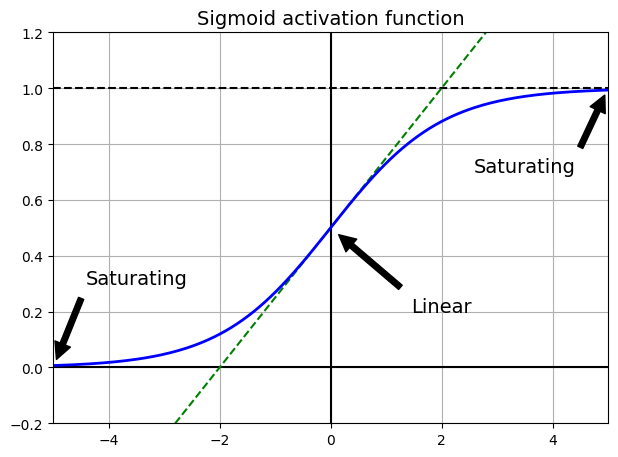

In [ ]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [ ]:
# Display all initializers in Keras
from tensorflow import keras
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [ ]:
#Initializer capable of adapting its scale to the shape of weights tensors
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

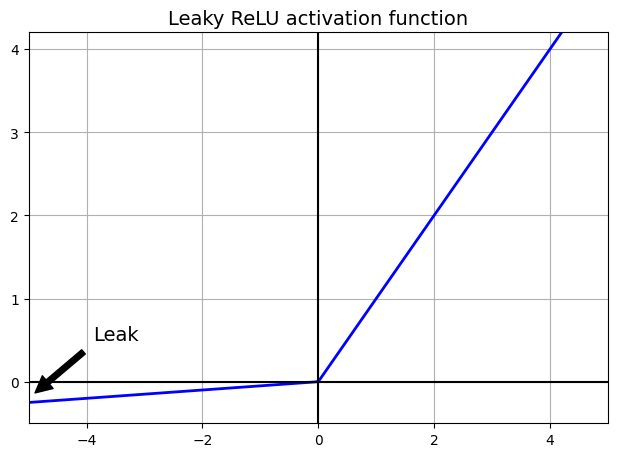

In [ ]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [ ]:
# DIspaly all activation functions in Keras
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'mish',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [ ]:
# Display all layers including "ReLU"
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [ ]:
## Fashion MNIST 데이터셋 준비 ##
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
## 모델 정의 ##
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
#from tensorflow.keras.backend.tensorflow_backend import set_session

#gpus = tf.config.list_physical_devices('GPU')
#cpus = tf.config.list_physical_devices('CPU')
#tf.config.set_visible_devices(cpus)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, use_multiprocessing=True,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 4ms/step - loss: 1.3261 - accuracy: 0.6020 - val_loss: 0.9088 - val_accuracy: 0.7192
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8191 - accuracy: 0.7368 - val_loss: 0.7233 - val_accuracy: 0.7706
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6964 - accuracy: 0.7745 - val_loss: 0.6473 - val_accuracy: 0.7940
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6310 - accuracy: 0.7943 - val_loss: 0.5902 - val_accuracy: 0.8108
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5892 - accuracy: 0.8071 - val_loss: 0.5564 - val_accuracy: 0.8184
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5598 - accuracy: 0.8141 - val_loss: 0.5315 - val_accuracy: 0.8252
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5378 - accuracy: 0.8212 - val_loss: 0.5124 - val_accuracy

Now let's try PReLU:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model1.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 1.2840 - accuracy: 0.6163 - val_loss: 0.8808 - val_accuracy: 0.7140
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8005 - accuracy: 0.7370 - val_loss: 0.7193 - val_accuracy: 0.7660
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6911 - accuracy: 0.7727 - val_loss: 0.6526 - val_accuracy: 0.7852
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6305 - accuracy: 0.7948 - val_loss: 0.5967 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5897 - accuracy: 0.8067 - val_loss: 0.5626 - val_accuracy: 0.8170
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5596 - accuracy: 0.8144 - val_loss: 0.5376 - val_accuracy: 0.8222
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5369 - accuracy: 0.8210 - val_loss: 0.5172 - val_accuracy:

### ELU

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

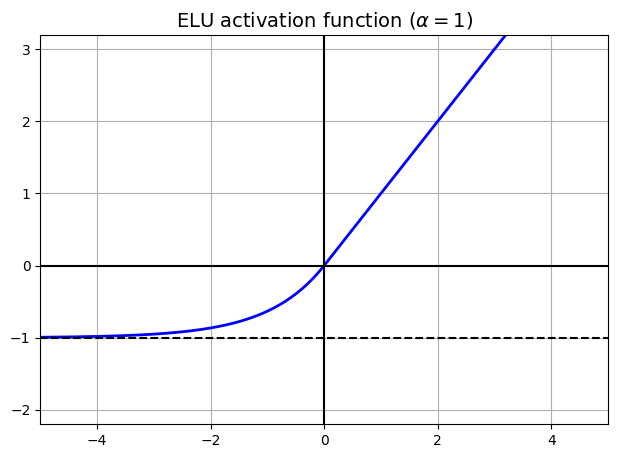

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [ ]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [ ]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

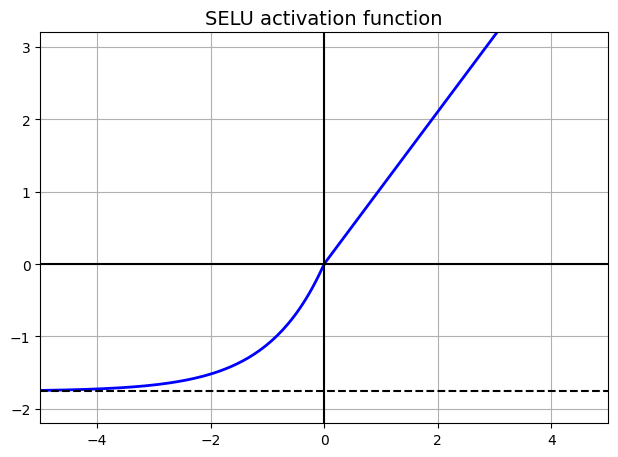

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [ ]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [ ]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)

model2 = keras.models.Sequential()
model2.add(keras.layers.Flatten(input_shape=[28, 28]))
model2.add(keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"))
model2.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model2.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model2.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model2.fit(X_train_scaled, y_train, epochs=10,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6991 - accuracy: 0.7603 - val_loss: 0.5223 - val_accuracy: 0.8264
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4975 - accuracy: 0.8267 - val_loss: 0.4665 - val_accuracy: 0.8466
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4572 - accuracy: 0.8397 - val_loss: 0.4455 - val_accuracy: 0.8522
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4337 - accuracy: 0.8481 - val_loss: 0.4278 - val_accuracy: 0.8572
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4174 - accuracy: 0.8540 - val_loss: 0.4166 - val_accuracy: 0.8634
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4045 - accuracy: 0.8582 - val_loss: 0.4092 - val_accuracy: 0.8606
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3943 - accuracy: 0.8623 - val_loss: 0.4005 - val_accuracy:

### Exercise 11.1  
####Ex.11.1a Build the same model as above with elu activation function, train the model, and compare the results. (The same training procedure as above)

#### Ex.11.1b Compare the results of loss, val_accuracy and training time for LeakyReLU, SELU, and ELU  



#### SELU activation in the very deep network  
Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model4 = keras.models.Sequential()
model4.add(keras.layers.Flatten(input_shape=[28, 28]))
model4.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model4.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model4.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model4.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model4.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 58s 25ms/step - loss: 1.5431 - accuracy: 0.3918 - val_loss: 1.5648 - val_accuracy: 0.3854
Epoch 2/5
1719/1719 [==============================] - 42s 25ms/step - loss: 1.6162 - accuracy: 0.3796 - val_loss: 1.4246 - val_accuracy: 0.4214
Epoch 3/5
1719/1719 [==============================] - 42s 25ms/step - loss: 1.4396 - accuracy: 0.4216 - val_loss: 1.5827 - val_accuracy: 0.3588
Epoch 4/5
1719/1719 [==============================] - 43s 25ms/step - loss: 1.4940 - accuracy: 0.4033 - val_loss: 1.4971 - val_accuracy: 0.3854
Epoch 5/5
1719/1719 [==============================] - 43s 25ms/step - loss: 1.3771 - accuracy: 0.4412 - val_loss: 1.2577 - val_accuracy: 0.4636


Now look at what happens if we try to use the ReLU activation function instead:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model5 = keras.models.Sequential()
model5.add(keras.layers.Flatten(input_shape=[28, 28]))
model5.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model5.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model5.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model5.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model5.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 60s 26ms/step - loss: 1.6862 - accuracy: 0.2958 - val_loss: 1.2996 - val_accuracy: 0.4736
Epoch 2/5
1719/1719 [==============================] - 45s 26ms/step - loss: 1.1849 - accuracy: 0.4881 - val_loss: 0.9799 - val_accuracy: 0.6218
Epoch 3/5
1719/1719 [==============================] - 48s 28ms/step - loss: 1.1537 - accuracy: 0.5259 - val_loss: 0.9116 - val_accuracy: 0.6494
Epoch 4/5
1719/1719 [==============================] - 42s 25ms/step - loss: 0.8879 - accuracy: 0.6484 - val_loss: 0.8075 - val_accuracy: 0.6900
Epoch 5/5
1719/1719 [==============================] - 43s 25ms/step - loss: 0.8116 - accuracy: 0.6896 - val_loss: 0.9217 - val_accuracy: 0.6128


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

In [ ]:
model6= keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_205 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_206 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)              

In [ ]:
bn1 = model6.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
model6.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model6.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8658 - accuracy: 0.7096 - val_loss: 0.5595 - val_accuracy: 0.8116
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5860 - accuracy: 0.7980 - val_loss: 0.4770 - val_accuracy: 0.8382
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5267 - accuracy: 0.8176 - val_loss: 0.4396 - val_accuracy: 0.8516
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4866 - accuracy: 0.8297 - val_loss: 0.4163 - val_accuracy: 0.8580
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4605 - accuracy: 0.8386 - val_loss: 0.4006 - val_accuracy: 0.8660
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4450 - accuracy: 0.8440 - val_loss: 0.3887 - val_accuracy: 0.8678
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4309 - accuracy: 0.8495 - val_loss: 0.3787 - val_accuracy

In [ ]:
# bn1 after training
bn1 = model6.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [ ]:
model7 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model7.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model7.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 1.0200 - accuracy: 0.6829 - val_loss: 0.6629 - val_accuracy: 0.7968
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6675 - accuracy: 0.7842 - val_loss: 0.5485 - val_accuracy: 0.8230
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5891 - accuracy: 0.8042 - val_loss: 0.4965 - val_accuracy: 0.8346
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5402 - accuracy: 0.8177 - val_loss: 0.4647 - val_accuracy: 0.8420
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5084 - accuracy: 0.8265 - val_loss: 0.4422 - val_accuracy: 0.8490
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4879 - accuracy: 0.8321 - val_loss: 0.4246 - val_accuracy: 0.8534
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4713 - accuracy: 0.8377 - val_loss: 0.4123 - val_accuracy

## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [ ]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
X_train_A.shape

(43986, 28, 28)

In [ ]:
X_train_B.shape

(200, 28, 28)

In [ ]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [ ]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 7s 4ms/step - loss: 0.5478 - accuracy: 0.8186 - val_loss: 0.3693 - val_accuracy: 0.8685
Epoch 2/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3466 - accuracy: 0.8805 - val_loss: 0.3162 - val_accuracy: 0.8901
Epoch 3/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3150 - accuracy: 0.8913 - val_loss: 0.2910 - val_accuracy: 0.8994
Epoch 4/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2975 - accuracy: 0.8988 - val_loss: 0.2787 - val_accuracy: 0.9063
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2852 - accuracy: 0.9029 - val_loss: 0.2701 - val_accuracy: 0.9076
Epoch 6/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2762 - accuracy: 0.9058 - val_loss: 0.2651 - val_accuracy: 0.9108
Epoch 7/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2682 - accuracy: 0.9087 - val_loss: 0.2627 - val_accuracy:

In [ ]:
model_A.save("my_model_A.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 2s 106ms/step - loss: 0.6017 - accuracy: 0.7450 - val_loss: 0.4718 - val_accuracy: 0.7972
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 0.3971 - accuracy: 0.8250 - val_loss: 0.3587 - val_accuracy: 0.8550
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 0.2992 - accuracy: 0.9000 - val_loss: 0.3005 - val_accuracy: 0.8884
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 0.2457 - accuracy: 0.9250 - val_loss: 0.2592 - val_accuracy: 0.9097
Epoch 5/20
7/7 [==============================] - 0s 17ms/step - loss: 0.2071 - accuracy: 0.9350 - val_loss: 0.2283 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 17ms/step - loss: 0.1770 - accuracy: 0.9700 - val_loss: 0.2058 - val_accuracy: 0.9341
Epoch 7/20
7/7 [==============================] - 0s 18ms/step - loss: 0.1552 - accuracy: 0.9700 - val_loss: 0.1867 - val_accuracy: 0.9442
Epoch 8/20
7/7 [==========

In [ ]:
model_A.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_211 (Dense)           (None, 300)               235500    
                                                                 
 dense_212 (Dense)           (None, 100)               30100     
                                                                 
 dense_213 (Dense)           (None, 50)                5050      
                                                                 
 dense_214 (Dense)           (None, 50)                2550      
                                                                 
 dense_215 (Dense)           (None, 50)                2550      
                                                                 
 dense_216 (Dense)           (None, 8)                

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
# replace output layer: 8 nodes -> 1 node
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
# Keep parameters of Model_A
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 44ms/step - loss: 1.3445 - accuracy: 0.3750 - val_loss: 1.2726 - val_accuracy: 0.3824
Epoch 2/4
7/7 [==============================] - 0s 16ms/step - loss: 1.2666 - accuracy: 0.3900 - val_loss: 1.1949 - val_accuracy: 0.4097
Epoch 3/4
7/7 [==============================] - 0s 30ms/step - loss: 1.1895 - accuracy: 0.3950 - val_loss: 1.1241 - val_accuracy: 0.4320
Epoch 4/4
7/7 [==============================] - 0s 17ms/step - loss: 1.1195 - accuracy: 0.4100 - val_loss: 1.0611 - val_accuracy: 0.4503
Epoch 1/16
7/7 [==============================] - 1s 46ms/step - loss: 0.9115 - accuracy: 0.5000 - val_loss: 0.6736 - val_accuracy: 0.5933
Epoch 2/16
7/7 [==============================] - 0s 17ms/step - loss: 0.5876 - accuracy: 0.6750 - val_loss: 0.4516 - val_accuracy: 0.7566
Epoch 3/16
7/7 [==============================] - 0s 18ms/step - loss: 0.4041 - accuracy: 0.8200 - val_loss: 0.3334 - val_accuracy: 0.8813
Epoch 4/16
7/7 [===============

So, what's the final verdict?

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0834 - accuracy: 0.9870


[0.08341237902641296, 0.9869999885559082]

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0835 - accuracy: 0.9870


[0.0834735855460167, 0.9869999885559082]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4!

In [ ]:
(100 - 97.05) / (100 - 99.35)

4.538461538461503

### Exercise 11.2  
"Reusing a Keras model" 부분에서 Fashion MNIST의 class 5,6,7을 제외하고 7개의 class로 학습하고 class 5,6,7에 대해 300개의 학습데이터를 이용하여 단독 학습한 결과와 transfer leranng을 이용한 경우에 대해 비교하시오. 제외시키는 class가 3개로 늘어난 것 외에는 모두 위의 실습 코드와 동일하게 작성하시오. 결과를 비교하고 분석하시오.

#### Ex.11.2d 결과비교

# Faster Optimizers

## Momentum optimization

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [ ]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## RMSProp

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## Adam Optimization

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Exercise 11.3  
Using Model6, cretae models from model6c to model6i for the above optimizers, train models and compare the results (training time and accuracy)

#### Ex.11.3b  
Compare the results

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.SGD.

In [ ]:
model7 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model7.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
n_epochs = 25
history7 = model7.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4724 - accuracy: 0.8338 - val_loss: 0.3671 - val_accuracy: 0.8638
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3474 - accuracy: 0.8743 - val_loss: 0.3973 - val_accuracy: 0.8634
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3077 - accuracy: 0.8857 - val_loss: 0.3344 - val_accuracy: 0.8768
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2812 - accuracy: 0.8955 - val_loss: 0.3287 - val_accuracy: 0.8836
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2589 - accuracy: 0.9028 - val_loss: 0.3281 - val_accuracy: 0.8874
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2410 - accuracy: 0.9104 - val_loss: 0.3317 - val_accuracy: 0.8864
Epoch 7/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2239 - accuracy: 0.9168 - val_loss: 0.3582 - val_accuracy:

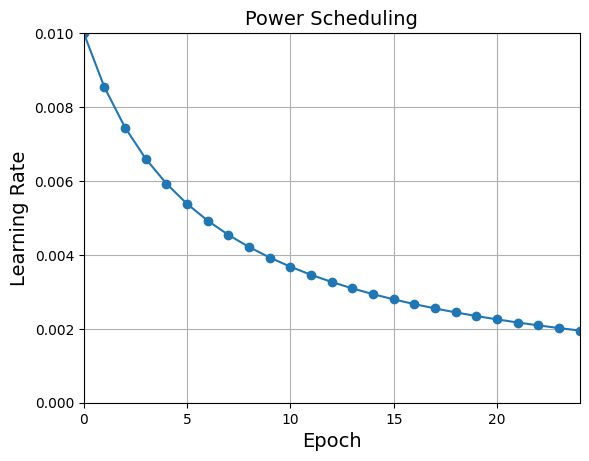

In [ ]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model8 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model8.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history8 = model8.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7354 - accuracy: 0.7780 - val_loss: 0.8520 - val_accuracy: 0.7734 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6539 - accuracy: 0.8009 - val_loss: 0.6648 - val_accuracy: 0.8226 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6148 - accuracy: 0.8174 - val_loss: 0.7779 - val_accuracy: 0.7864 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5527 - accuracy: 0.8294 - val_loss: 0.5379 - val_accuracy: 0.8360 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5046 - accuracy: 0.8404 - val_loss: 0.4754 - val_accuracy: 0.8492 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4589 - accuracy: 0.8536 - val_loss: 0.4996 - val_accuracy: 0.8534 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 6s

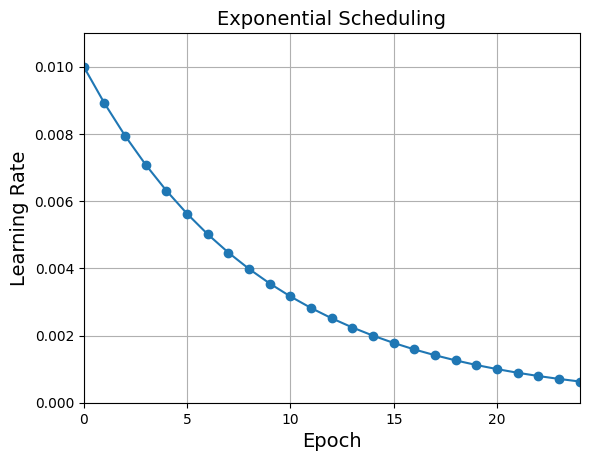

In [ ]:
plt.plot(history8.epoch, history8.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model9 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer9 = keras.optimizers.Nadam(learning_rate=lr0)
model9.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer9, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history9 = model9.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7071 - accuracy: 0.7868 - val_loss: 0.6379 - val_accuracy: 0.8062 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5909 - accuracy: 0.8163 - val_loss: 0.5073 - val_accuracy: 0.8488 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5799 - accuracy: 0.8205 - val_loss: 0.5765 - val_accuracy: 0.8412 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5399 - accuracy: 0.8353 - val_loss: 0.5117 - val_accuracy: 0.8332 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4825 - accuracy: 0.8483 - val_loss: 0.5306 - val_accuracy: 0.8530 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4397 - accuracy: 0.8579 - val_loss: 0.4708 - val_accuracy: 0.8586 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 8s

In [ ]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

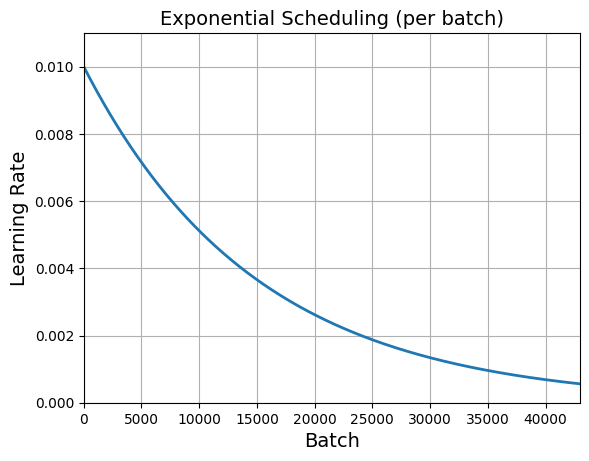

In [ ]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model10 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model10.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history10 = model10.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7539 - accuracy: 0.7765 - val_loss: 0.7044 - val_accuracy: 0.8228 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7647 - accuracy: 0.7791 - val_loss: 0.8285 - val_accuracy: 0.7528 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8010 - accuracy: 0.7754 - val_loss: 0.9864 - val_accuracy: 0.7530 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8962 - accuracy: 0.7349 - val_loss: 0.8949 - val_accuracy: 0.7456 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.9653 - accuracy: 0.6835 - val_loss: 0.8502 - val_accuracy: 0.6866 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6369 - accuracy: 0.7833 - val_loss: 0.6704 - val_accuracy: 0.8252 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 6s

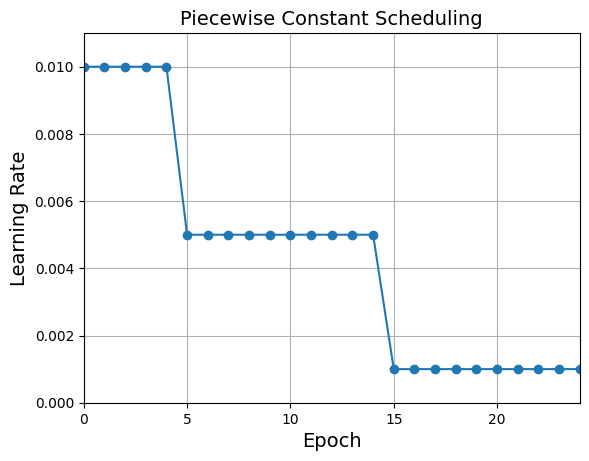

In [ ]:
plt.plot(history10.epoch, [piecewise_constant_fn(epoch) for epoch in history10.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model11 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer11= keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model11.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer11, metrics=["accuracy"])
n_epochs = 25
history11 = model11.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 3ms/step - loss: 0.5950 - accuracy: 0.8048 - val_loss: 0.4407 - val_accuracy: 0.8514 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4938 - accuracy: 0.8413 - val_loss: 0.6060 - val_accuracy: 0.8358 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4998 - accuracy: 0.8437 - val_loss: 0.5291 - val_accuracy: 0.8574 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5073 - accuracy: 0.8480 - val_loss: 0.5104 - val_accuracy: 0.8578 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5152 - accuracy: 0.8505 - val_loss: 0.5209 - val_accuracy: 0.8382 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5037 - accuracy: 0.8555 - val_loss: 0.6595 - val_accuracy: 0.8508 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 6s

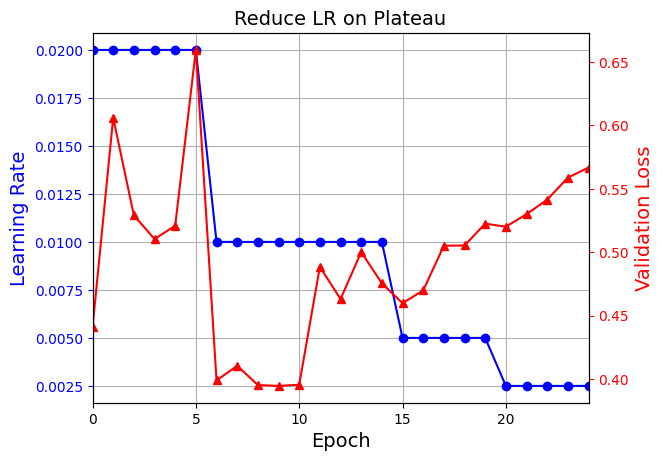

In [ ]:
plt.plot(history11.epoch, history11.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history11.epoch, history11.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [ ]:
model12 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

print(X_train.shape)
print(len(X_train))
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
print (s)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer12 = keras.optimizers.SGD(learning_rate)
model12.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer12, metrics=["accuracy"])
n_epochs = 25
history12 = model12.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

(55000, 28, 28)
55000
34375
Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4902 - accuracy: 0.8278 - val_loss: 0.4058 - val_accuracy: 0.8612
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3780 - accuracy: 0.8661 - val_loss: 0.3701 - val_accuracy: 0.8730
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3438 - accuracy: 0.8783 - val_loss: 0.3733 - val_accuracy: 0.8732
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3221 - accuracy: 0.8853 - val_loss: 0.3480 - val_accuracy: 0.8786
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3062 - accuracy: 0.8912 - val_loss: 0.3423 - val_accuracy: 0.8776
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2919 - accuracy: 0.8961 - val_loss: 0.3430 - val_accuracy: 0.8824
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2816 - accuracy: 0.9004 - val_

For piecewise constant scheduling, try this:

In [ ]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### Exercise 11.4  
Train the model using the above learning rate scheduler

### 1Cycle scheduling

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model14 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model14.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.6267


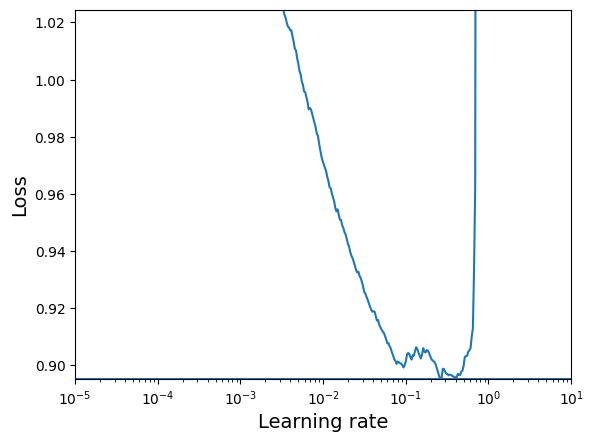

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history14 = model14.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.6733 - accuracy: 0.7660 - val_loss: 0.4869 - val_accuracy: 0.8346
Epoch 2/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4571 - accuracy: 0.8409 - val_loss: 0.4266 - val_accuracy: 0.8544
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4104 - accuracy: 0.8559 - val_loss: 0.4108 - val_accuracy: 0.8592
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3808 - accuracy: 0.8654 - val_loss: 0.3847 - val_accuracy: 0.8704
Epoch 5/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3602 - accuracy: 0.8720 - val_loss: 0.3694 - val_accuracy: 0.8722
Epoch 6/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3417 - accuracy: 0.8784 - val_loss: 0.3674 - val_accuracy: 0.8766
Epoch 7/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3289 - accuracy: 0.8826 - val_loss: 0.3510 - val_accuracy: 0.8778
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 1.5713 - accuracy: 0.8132 - val_loss: 0.7052 - val_accuracy: 0.8376
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7220 - accuracy: 0.8268 - val_loss: 0.6926 - val_accuracy: 0.8320


In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 1.6074 - accuracy: 0.8134 - val_loss: 0.7077 - val_accuracy: 0.8382
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7237 - accuracy: 0.8263 - val_loss: 0.6878 - val_accuracy: 0.8346


## Dropout

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 4ms/step - loss: 0.5656 - accuracy: 0.8051 - val_loss: 0.3610 - val_accuracy: 0.8668
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4233 - accuracy: 0.8454 - val_loss: 0.3456 - val_accuracy: 0.8768


## Alpha Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6619 - accuracy: 0.7603 - val_loss: 0.5913 - val_accuracy: 0.8442
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5551 - accuracy: 0.7952 - val_loss: 0.5702 - val_accuracy: 0.8390
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5250 - accuracy: 0.8038 - val_loss: 0.5004 - val_accuracy: 0.8526
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5052 - accuracy: 0.8119 - val_loss: 0.4625 - val_accuracy: 0.8628
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4887 - accuracy: 0.8191 - val_loss: 0.4507 - val_accuracy: 0.8612
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4799 - accuracy: 0.8216 - val_loss: 0.4625 - val_accuracy: 0.8602
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4695 - accuracy: 0.8258 - val_loss: 0.4770 - val_accuracy:

In [ ]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4539 - accuracy: 0.8589


[0.4539366662502289, 0.8589000105857849]

In [ ]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 4s 2ms/step - loss: 0.3376 - accuracy: 0.8791


[0.3375762701034546, 0.8791272640228271]

In [ ]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.4208 - accuracy: 0.8438


## MC Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 137ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.07, 0.  , 0.82]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.08, 0.  , 0.78]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.05, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.1 , 0.  , 0.68]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.01, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.74, 0.  , 0.06, 0.  , 0.2 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.33, 0.  , 0.5 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.31, 0.  , 0.66]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.02, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.01, 0.  , 0.83]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.38, 0.  , 0.52]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.06, 0.  , 0.74]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0

In [ ]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.19, 0.  , 0.71]],
      dtype=float32)

In [ ]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.21, 0.  , 0.23]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.87

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
mc_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaD  (None, 784)               0         
 ropout)                                                         
                                                                 
 dense_242 (Dense)           (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlph  (None, 300)               0         
 aDropout)                                                       
                                                                 
 dense_243 (Dense)           (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlph  (None, 100)             

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 17ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.23, 0.  , 0.65]],
      dtype=float32)

## Max norm

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 4ms/step - loss: 0.4663 - accuracy: 0.8359 - val_loss: 0.3567 - val_accuracy: 0.8684
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3565 - accuracy: 0.8702 - val_loss: 0.4001 - val_accuracy: 0.8598


### Exercise 11.5  
### 8. Deep Learning on CIFAR10

- 이번 문제는 컴퓨터 성능에 따라 학번의 학습이 몇시간이 걸릴 수 있으니 GPU가 설치된 고성능 PC나 colab에서 실행 권장  
- 자율실습실(형남 1302/3호) 또는 차세대반도체학과 실습실(조만식 427호: 예약제)

### a.
히든 레이어 20개, 각 레이어 당 100개의 뉴런을 가진 DNN 모델을 구축하시요. 이 때 He initilization 과 ELU activation function 을 사용하시오

### b.
Nadam optimization 과 early stopping을 사용하여, 위에서 구축한 모델을 CIFAR10 dataset으로 학습하시오.

CIFAR10 데이터셋 로드: keras.datasets.cifar10.load_data()
CIFAR10 데이터셋: 총 10개의 class 존재


참고)학습 때 모델 구조 또는 하이퍼파라미터 변경 시마다 적절한 learning rate 를 찾을 것.

Let's add the output layer to the model:

Nadam optimizer, Learningrate:5e-5를 사용해보자

CIRAR10데이터셋 로드하기


early stopping 추가 위해 validation set 설정(training set의 초반 5000개 이미지)

analysis of CIFAR 10 dataset. Refer the cells 14-23 of chap. 10

Now we can create the callbacks for tensorboard and early stopping and train the model:

### c.
BatchNormalization 추가하여 Learning Curves 비교하기
- 수렴 속도, 성능, 학습 속도 등

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 10 epochs.
* I renamed the run directories to run_bn_* and the model file name to my_cifar10_bn_model.h5.

* *Is the model converging faster than before?* Much faster! The previous model took OO epochs to reach the lowest validation loss, while the new model with BN took OO epochs. That's more than twice as fast as the previous model. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with OO% accuracy instead of OO%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged twice as fast, each epoch took about OOs instead of OOs, because of the extra computations required by the BN layers. So overall, although the number of epochs was reduced by OO%, the training time (wall time) was shortened by OO%. Which is still pretty significant!

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

We get OO.O% accuracy, which is better than the original model, but not quite as good as the model using batch normalization. Moreover, it took OO epochs to reach the best model, which is much faster than both the original model and the BN model, plus each epoch took only OO seconds, just like the original model. So it's by far the fastest model to train (both in terms of epochs and wall time).

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

The model reaches OO.O% accuracy on the validation set. That's very slightly worse than without dropout (OO.O%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

We only get virtually no accuracy improvement in this case (from OO.O% to OO.O%).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

One cycle allowed us to train the model in just OO epochs, each taking only O seconds (thanks to the larger batch size). This is over O times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from OO.O% to OO.O%). The batch normalized model reaches a slightly better performance, but it's much slower to train.